In [339]:
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import random
import mpmath as mp
plt.style.use('default')
#myColor  = ("#E3072A","#0A8974","#5FAECC","#E49C23","#E27520") # Darjeeling Color map
myColor  = ("#E3072A","#0A8974","#5FAECC") # Darjeeling Color map

In [340]:
import HALS as hals

In [341]:
# Earth tide frequencies
et_fqs = {'Q1': 0.893244, 'O1': 0.929536, 'M1': 0.966446, 'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'N2': 1.895982, 'M2': 1.932274, 'S2': 2.0, 'K2': 2.005476}
# Atmospheric tide frquencies
at_fqs = {'P1': 0.997262, 'S1': 1.0, 'K1': 1.002738, 'S2': 2.0, 'K2': 2.005476}

In [342]:
folder = "test_data"
file = "J_beforeEQ"
raw_data = pd.read_csv(folder + '/' + file + '_data.csv')
raw_data.iloc[0]

Datetime                01/01/2013 00:00
Atm. pressure [mbar]               900.5
J6 [m]                             16.11
J7 [m]                              9.78
JC [m]                             50.32
Volume strain                   1.216598
Name: 0, dtype: object

In [343]:
# search for a datetime column
dt_col = raw_data.columns[raw_data.columns.str.contains('datetime', case=False)][0]
# streamline the column format
raw_data[dt_col] = pd.to_datetime(raw_data[dt_col],dayfirst=True)

# create a numeric value column
dnum_col = pd.to_numeric(raw_data[dt_col])
dnum_col = (dnum_col-dnum_col[0])
dnum_col = dnum_col/ 10**9 # from ns to seconds
dnum_col = dnum_col/(60*60*24) # to days

raw_data.insert(0,"dnum",dnum_col)
raw_data.dnum

0          0.000000
1          0.041667
2          0.083333
3          0.125000
4          0.166667
            ...    
10936    455.666667
10937    455.708333
10938    455.750000
10939    455.791667
10940    455.833333
Name: dnum, Length: 10941, dtype: float64

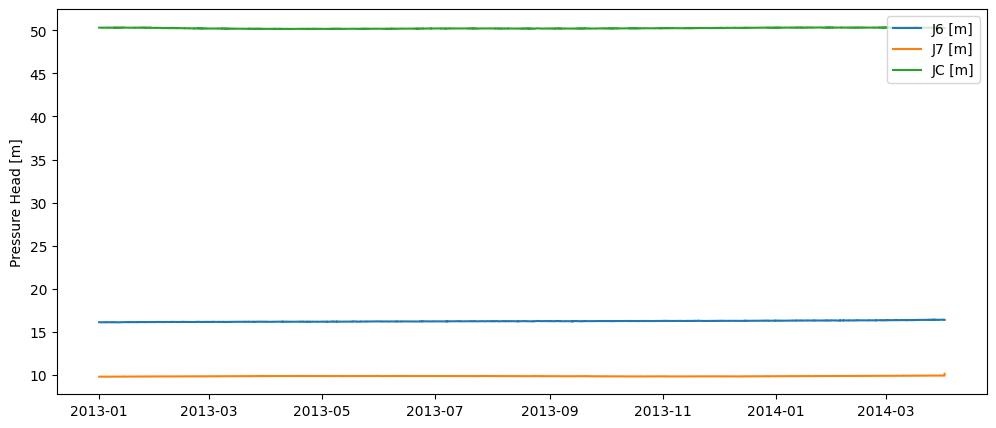

In [344]:
gw_col = list(raw_data.columns[raw_data.columns.str.contains('J', case=False)])
fig, ax = plt.subplots(nrows= 1,figsize=(12.0,5.0), sharex = True) # ,sharey=True
for name,i in zip(gw_col,range(len(gw_col))):
    gw = raw_data[name]
    # Groundwater Head Measurements    
    ax.plot(raw_data[dt_col],gw,label=name)
    ax.set_ylabel("Pressure Head [m]")
    ax.legend(loc="upper right")

In [345]:
#timestart=0
#timeend=10940#before jump
timestart=0
#timeend=30*24*(12+10)#(day*hour*month)#after jump
timeend=10940
print(raw_data[dt_col][10940]) 
df_gaps=raw_data[timestart:timeend]

2014-04-01 20:00:00


,dnum,J6 [m],J7 [m],JC [m]
0,0.000000,0.004755,0.001000,0.001322
1,0.041667,0.004996,0.000974,0.001718
2,0.083333,0.005237,0.000948,0.002114
3,0.125000,0.005478,0.000922,0.012509
4,0.166667,-0.004282,0.000896,0.002905
...,...,...,...,...
10935,455.625000,0.001145,0.001857,0.007649
10936,455.666667,0.001738,0.002356,-0.001176
10937,455.708333,-0.007670,-0.007146,-0.010001
10938,455.750000,-0.007077,-0.006647,-0.008826


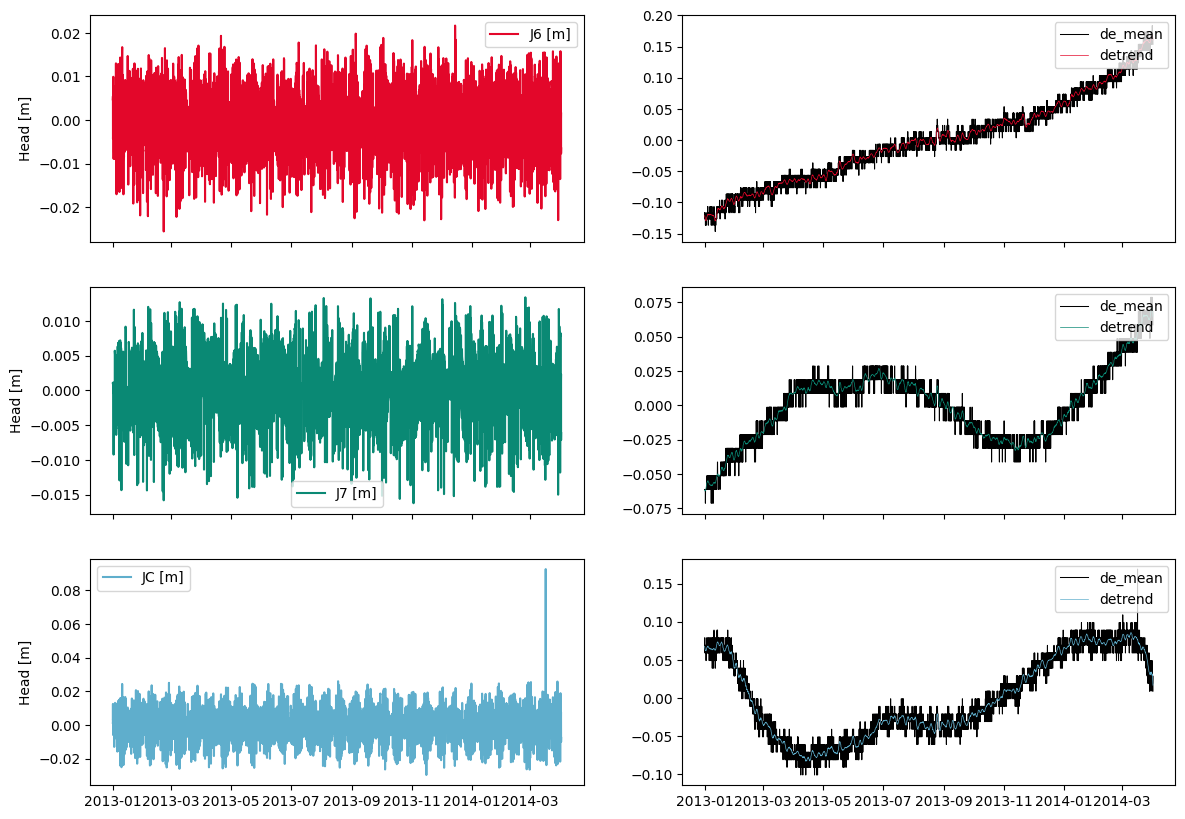

In [346]:
length = 3.0 # length of the detrend window
stopper = 3 # minimum number of samples in window
n_ovrlp = 5 # number of window overlaps

fig, ax = plt.subplots(nrows= len(gw_col),ncols=2,figsize=(14.0,10.0), sharex = True) # ,sharey=True
# create a new dataframe for the detrended data
df_detr = pd.DataFrame(df_gaps.dnum,columns = ["dnum"])
for name,i in zip(gw_col,range(len(gw_col))):
    gw = df_gaps[name]
    # detrending of the data
    df_detr[name] = hals.lin_window_ovrlp(df_gaps.dnum, gw.values,length=length,stopper=stopper,n_ovrlp=n_ovrlp)
    ax[i,0].plot(df_gaps[dt_col],df_detr[name], label = name, color=myColor[i])
    ax[i,0].legend()
    ax[i,0].set_ylabel("Head [m]")
    de_mean = gw.values - np.nanmean(gw.values)
    ax[i,1].plot(df_gaps[dt_col], de_mean, label='de_mean', lw=0.75,color="black")
    ax[i,1].plot(df_gaps[dt_col], de_mean - df_detr[name], label='detrend', lw=0.5, color=myColor[i])
    ax[i,1].legend(loc="upper right")
df_detr  

In [347]:
freqs = {**et_fqs, **at_fqs}

# create new dataframes for the amplitude and phase results
df_A = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])
df_phi = pd.DataFrame.from_dict(freqs,orient="index",columns=["freqs"])

# loop over the groundwater head measurement data sets
for name,i in zip(gw_col,range(len(gw_col))):
    gw = df_detr[name]
    #HALS function
    output = hals.hals_lsq(df_detr.dnum.values, gw.values, list(freqs.values()))
    df_A[name] = output[0] #Amplitudes
    df_phi[name] = output[1]*180/np.pi #Phases
    
df_A    

Conditioning number:  1.5788777001261858
Conditioning number:  1.5788777001261858
Conditioning number:  1.5788777001261858


,freqs,J6 [m],J7 [m],JC [m]
Q1,0.893244,0.000084,0.000140,0.000347
O1,0.929536,0.000870,0.000616,0.002070
M1,0.966446,0.000103,0.000080,0.000135
P1,0.997262,0.000300,0.000268,0.000305
S1,1.000000,0.004310,0.002918,0.003956
K1,1.002738,0.000369,0.000250,0.001545
N2,1.895982,0.000615,0.000456,0.001478
M2,1.932274,0.003409,0.002454,0.008159
S2,2.000000,0.005549,0.003305,0.007131
K2,2.005476,0.000452,0.000178,0.000985


In [348]:
 df_phi

,freqs,J6 [m],J7 [m],JC [m]
Q1,0.893244,-122.313153,-87.102618,-107.077013
O1,0.929536,135.153356,136.038932,137.885919
M1,0.966446,24.058479,-4.151637,48.563928
P1,0.997262,31.434149,42.353271,-79.056818
S1,1.000000,20.851037,34.183437,28.157918
K1,1.002738,-85.804835,-129.254776,-77.460489
N2,1.895982,59.683632,89.018144,64.125545
M2,1.932274,-43.826528,-27.020670,-39.869552
S2,2.000000,104.307998,120.311708,88.199676
K2,2.005476,-66.390020,-45.730773,-81.886359


In [349]:
 output

(array([0.00034708, 0.00206982, 0.00013515, 0.00030477, 0.00395594,
        0.00154534, 0.00147835, 0.00815933, 0.00713137, 0.00098462]),
 array([-1.86884643,  2.40656328,  0.84760045, -1.37980177,  0.49144837,
        -1.35194057,  1.1192019 , -0.69585495,  1.53937475, -1.42918658]),
 1.5158397435537144e-05,
 array([-3.31775395e-04, -1.01921750e-04,  1.38803846e-03, -1.53541388e-03,
         1.01318224e-04,  8.94374589e-05, -2.99225187e-04,  5.78556021e-05,
         1.86682041e-03,  3.48775400e-03, -1.50847993e-03,  3.35513485e-04,
         1.33014696e-03,  6.45151942e-04, -5.23046987e-03,  6.26233159e-03,
         7.12784924e-03,  2.24041997e-04, -9.74760365e-04,  1.38965720e-04,
        -3.68085885e-07]),
 array([ 0.00346909,  0.00726007,  0.0094866 , ..., -0.008437  ,
        -0.01268398, -0.01448575]))

Conditioning number:  1.5788777001261858


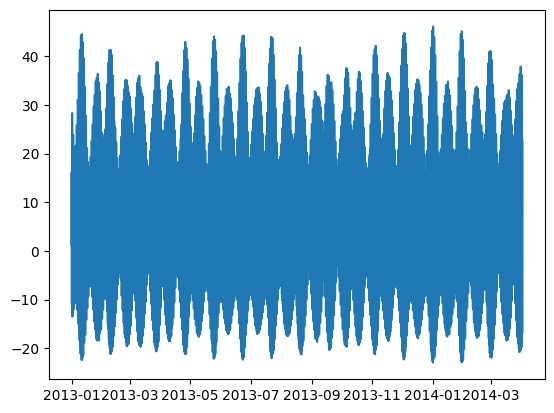

In [350]:
et=raw_data['Volume strain']
et=et[timestart:timeend]
plt.plot(df_gaps[dt_col],et)
output1 = hals.hals_lsq(df_detr.dnum.values, et-np.mean(et), list(freqs.values()))
et_detr=et-np.mean(et)
et_A = output1[0] #Amplitudes
et_phi = output1[1]*180/np.pi #Phases

Conditioning number:  1.5788777001261858


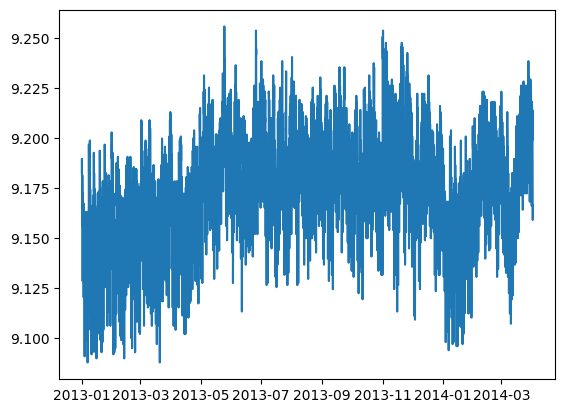

In [351]:
bp=raw_data['Atm. pressure [mbar]']*10.1972/1000
bp=bp[timestart:timeend]
plt.plot(df_gaps[dt_col],bp)
bp_detr = hals.lin_window_ovrlp(df_gaps.dnum, bp.values,length=length,stopper=stopper,n_ovrlp=n_ovrlp)
output2 = hals.hals_lsq(df_detr.dnum.values, bp_detr, list(freqs.values()))

In [352]:
et_A

array([7.76852494e-01, 4.08537808e+00, 2.79670327e-01, 2.21567545e+00,
       1.36100303e-02, 6.07397652e+00, 3.22746606e+00, 1.65769669e+01,
       7.54947575e+00, 1.67881235e+00])

In [353]:
df_phi.loc['M2',gw_col]-et_phi[7]

J6 [m]   -20.537072
J7 [m]    -3.731215
JC [m]   -16.580096
Name: M2, dtype: float64

In [354]:
J6_gw=df_detr.iloc[:,1]
J7_gw=df_detr.iloc[:,2]
JC_gw=df_detr.iloc[:,3]

In [355]:
J6_output = hals.hals_lsq(df_detr.dnum.values[30*24:90*24], J6_gw.values[30*24:90*24], list(freqs.values()))
a6=J6_output[0]
print(a6)
a6_m2=[]
a6_m2.append(a6[7])
a6_m2
df_detr.dnum.values[2]


Conditioning number:  53.10906162342595
[0.00021517 0.00066578 0.00034106 0.00474488 0.00960948 0.00457778
 0.00067433 0.0032819  0.00571214 0.00032686]


0.08333333333333333

In [356]:
dt=raw_data[dt_col]
dt=dt[timestart:timeend]
print(dt)

0       2013-01-01 00:00:00
1       2013-01-01 01:00:00
2       2013-01-01 02:00:00
3       2013-01-01 03:00:00
4       2013-01-01 04:00:00
                ...        
10935   2014-04-01 15:00:00
10936   2014-04-01 16:00:00
10937   2014-04-01 17:00:00
10938   2014-04-01 18:00:00
10939   2014-04-01 19:00:00
Name: Datetime, Length: 10940, dtype: datetime64[ns]


In [357]:
df_detr.dnum

0          0.000000
1          0.041667
2          0.083333
3          0.125000
4          0.166667
            ...    
10935    455.625000
10936    455.666667
10937    455.708333
10938    455.750000
10939    455.791667
Name: dnum, Length: 10940, dtype: float64

In [358]:
datestamp=[]
J6_gwamp=[]
J6_gwampstd=[]
J6_gwpha=[]
J6_gwphastd=[]
J7_gwamp=[]
J7_gwampstd=[]
J7_gwpha=[]
J7_gwphastd=[]
JC_gwamp=[]
JC_gwampstd=[]
JC_gwpha=[]
JC_gwphastd=[]
ET_amp=[]
ET_pha=[]

J6_gwamp_s2=[]
J6_gwpha_s2=[]
J7_gwamp_s2=[]
J7_gwpha_s2=[]
JC_gwamp_s2=[]
JC_gwpha_s2=[]
ET_amp_s2=[]
ET_pha_s2=[]
BP_amp_s2=[]
BP_pha_s2=[]

a=0;b=60*24
while b<timeend:
#while b<10940:
    
    J6_output = hals.hals_lsq(df_detr.dnum.values[a:b], J6_gw.values[a:b], list(freqs.values()))
    J7_output = hals.hals_lsq(df_detr.dnum.values[a:b], J7_gw.values[a:b], list(freqs.values()))
    JC_output = hals.hals_lsq(df_detr.dnum.values[a:b], JC_gw.values[a:b], list(freqs.values()))
    ET_output = hals.hals_lsq(df_detr.dnum.values[a:b], et_detr[a:b], list(freqs.values()))
    BP_output = hals.hals_lsq(df_detr.dnum.values[a:b], bp_detr[a:b], list(freqs.values()))
    J6_amp=J6_output[0]
    J6_pha=J6_output[1]
    J6_ampstd=J6_output[2] #I'm not sure those are  error
    J6_phastd=J6_output[3]
    J7_amp=J7_output[0]
    J7_pha=J7_output[1]
    J7_ampstd=J7_output[2]
    J7_phastd=J7_output[3]
    JC_amp=JC_output[0]
    JC_pha=JC_output[1]
    JC_ampstd=JC_output[2]
    JC_phastd=JC_output[3]
    et_amp=ET_output[0]
    et_pha=ET_output[1]
    bp_amp=BP_output[0]
    bp_pha=BP_output[1]    
    datestamp.append(dt[round((a+b)/2)+timestart])
    #extract M2
    J6_gwamp.append(J6_amp[7]) 
    #J6_gwampstd.append(J6_ampstd[7]) 
    J6_gwpha.append(J6_pha[7])
    #J6_gwphastd.append(J6_phastd[7])
    J7_gwamp.append(J7_amp[7]) 
    #J7_gwampstd.append(J7_ampstd[7]) 
    J7_gwpha.append(J7_pha[7])
    #J7_gwphastd.append(J7_phastd[7])
    JC_gwamp.append(JC_amp[7]) 
    #JC_gwampstd.append(JC_ampstd[7]) 
    JC_gwpha.append(JC_pha[7])
    #JC_gwphastd.append(JC_phastd[7])
    ET_amp.append(et_amp[7])
    ET_pha.append(et_pha[7])
    
        #extract S2
    J6_gwamp_s2.append(J6_amp[8]) 
    J6_gwpha_s2.append(J6_pha[8])
    J7_gwamp_s2.append(J7_amp[8]) 
    J7_gwpha_s2.append(J7_pha[8])
    JC_gwamp_s2.append(JC_amp[8]) 
    JC_gwpha_s2.append(JC_pha[8])
    ET_amp_s2.append(et_amp[8])
    ET_pha_s2.append(et_pha[8])
    BP_amp_s2.append(bp_amp[8])
    BP_pha_s2.append(bp_pha[8])
    
    a+=5*24
    b+=5*24

Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.1090616234256
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425816
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.109061623425866
Conditioning number:  53.10906162342611
Conditioning number:  53.10906162342611
Conditioning number:  53.10906162342611
Conditioning number:  53.10906162342611
Conditioning number:  53.1090616234

Conditioning number:  53.109061623425326
Conditioning number:  53.10906162342537
Conditioning number:  53.10906162342537
Conditioning number:  53.10906162342537
Conditioning number:  53.10906162342537
Conditioning number:  53.10906162342537
Conditioning number:  53.10906162342535
Conditioning number:  53.10906162342535
Conditioning number:  53.10906162342535
Conditioning number:  53.10906162342535
Conditioning number:  53.10906162342535
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342546
Conditioning number:  53.10906162342549
Conditioning number:  53.10906162342549
Conditioning number:  53.10906162342549
Conditioning number:  53.10906162342549
Conditioning number:  53.10906162342549
Conditioning number:  53.109061623425454
Conditioning number:  53.109061623425454
Conditioning number:  53.109061623425454
Conditioning number:  53.10906162342

In [359]:
def pi_range(value):
    value = np.array(value)
    idx = (value > 180)
    value[idx] -= 360
    idx = (value < -180)
    value[idx] += 360
    return value

In [360]:
J6gw_et_s2 = np.asarray(J6_gwamp_s2)-np.asarray(J6_gwamp)/ np.asarray(ET_amp)*np.asarray(ET_amp_s2)
J7gw_et_s2 = np.asarray(J7_gwamp_s2)-np.asarray(J7_gwamp)/ np.asarray(ET_amp)*np.asarray(ET_amp_s2)
JCgw_et_s2 = np.asarray(JC_gwamp_s2)-np.asarray(JC_gwamp)/ np.asarray(ET_amp)*np.asarray(ET_amp_s2)

J6_Be=J6gw_et_s2 /np.asarray(BP_amp_s2)
J7_Be=J7gw_et_s2 /np.asarray(BP_amp_s2)
JC_Be=JCgw_et_s2 /np.asarray(BP_amp_s2)

J6_BPs=(pi_range(np.asarray(J6_gwpha_s2)*180/np.pi-np.asarray(BP_pha_s2)*180/np.pi))
J7_BPs=(pi_range(np.asarray(J7_gwpha_s2)*180/np.pi-np.asarray(BP_pha_s2)*180/np.pi))
JC_BPs=(pi_range(np.asarray(JC_gwpha_s2)*180/np.pi-np.asarray(BP_pha_s2)*180/np.pi))

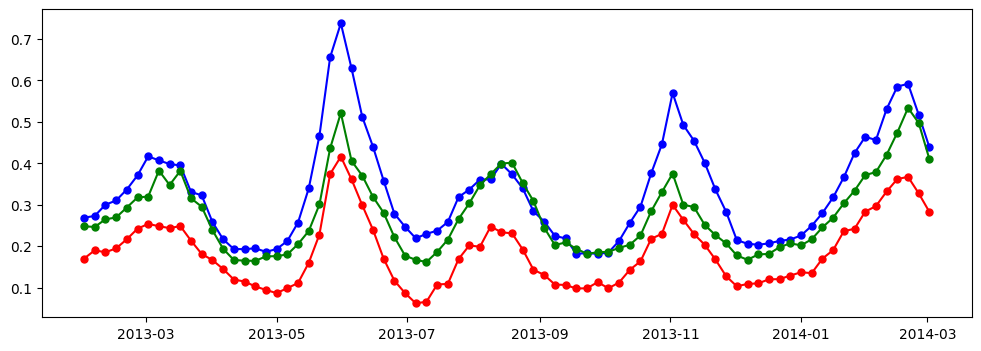

In [361]:
Date=np.asarray(datestamp)
fig=plt.figure(figsize=(12, 4))
ax=fig.add_subplot(111)
#ax.set_title('Phase shift(without errorbar) with time for wells J6, J7 and JC',fontsize=15, fontweight='bold')d')
ax.plot(Date,J6_Be, 'b.-', ms=10,label='Well_J6 ')
ax.plot(Date,J7_Be, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,JC_Be, 'g.-', ms=10,label='Well_JC ')

In [362]:
Date=np.asarray(datestamp)
J6_Ps=(pi_range(np.asarray(J6_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
J7_Ps=(pi_range(np.asarray(J7_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
JC_Ps=(pi_range(np.asarray(JC_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
J6_Ar=np.asarray(J6_gwamp)/ np.asarray(ET_amp)*1e9
J7_Ar=np.asarray(J7_gwamp)/ np.asarray(ET_amp)*1e9
JC_Ar=np.asarray(JC_gwamp)/ np.asarray(ET_amp)*1e9

import csv
# with open('before jump.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Date','J6_Ps', 'J7_Ps', 'JC_Ps', 'J6_Ar','J7_Ar','JC_Ar'])
#     for row in zip(Date,J6_Ps, J7_Ps, JC_Ps, J6_Ar, J7_Ar, JC_Ar):
#         writer.writerow(row)
        
with open('J before jump.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Date','J6_Ps', 'J7_Ps', 'JC_Ps', 'J6_Ar','J7_Ar','JC_Ar','J6_BPs', 'J7_BPs', 'JC_BPs', 'J6_Be','J7_Be','JC_Be'])
    for row in zip(Date,J6_Ps, J7_Ps, JC_Ps, J6_Ar, J7_Ar, JC_Ar,J6_BPs, J7_BPs, JC_BPs, J6_Be, J7_Be, JC_Be):
        writer.writerow(row)

In [363]:
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8,
}

In [364]:
# bj=pd.read_csv('del jump.csv')
# J6_Ps=bj['J6_Ps']
# J7_Ps=bj['J7_Ps']
# JC_Ps=bj['JC_Ps']

# J6_Ar=bj['J6_Ar']
# J7_Ar=bj['J7_Ar']
# JC_Ar=bj['JC_Ar']

# Date=bj['Date']

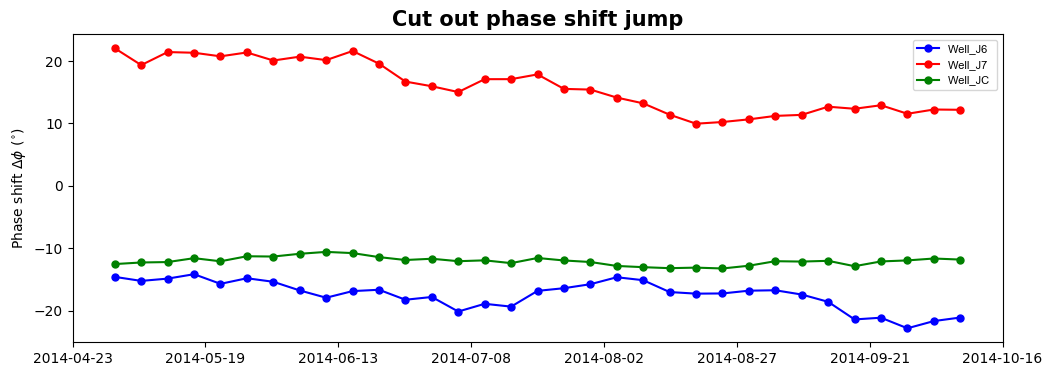

In [120]:
#Date=np.asarray(datestamp)
# J6_Ps=(pi_range(np.asarray(J6_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
# J7_Ps=(pi_range(np.asarray(J7_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
# JC_Ps=(pi_range(np.asarray(JC_gwpha)*180/np.pi-np.asarray(ET_pha)*180/np.pi))
fig=plt.figure(figsize=(12, 4))
ax=fig.add_subplot(111)
#ax.set_title('Phase shift(without errorbar) with time for wells J6, J7 and JC',fontsize=15, fontweight='bold')
ax.set_title('Cut out phase shift jump',fontsize=15, fontweight='bold')
ax.plot(Date,J6_Ps, 'b.-', ms=10,label='Well_J6 ')
ax.plot(Date,J7_Ps, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,JC_Ps, 'g.-', ms=10,label='Well_JC ')
ax.set_ylabel("Phase shift $\Delta \phi$ ($^{\circ}$)",fontsize=10)
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator

ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# ax.axvline(x=Date[80],ls="--",c="#E3072A")
# print(Date[80])
# ax.text(Date[80],-8,'earthquake',  rotation=-90)
#There may be some mistakes in the previous results, please check this one
ax.legend(prop=font1)
fig.savefig('del jump_P.svg',bbox_inches='tight')
fig.savefig('del jump_P.png',bbox_inches='tight')

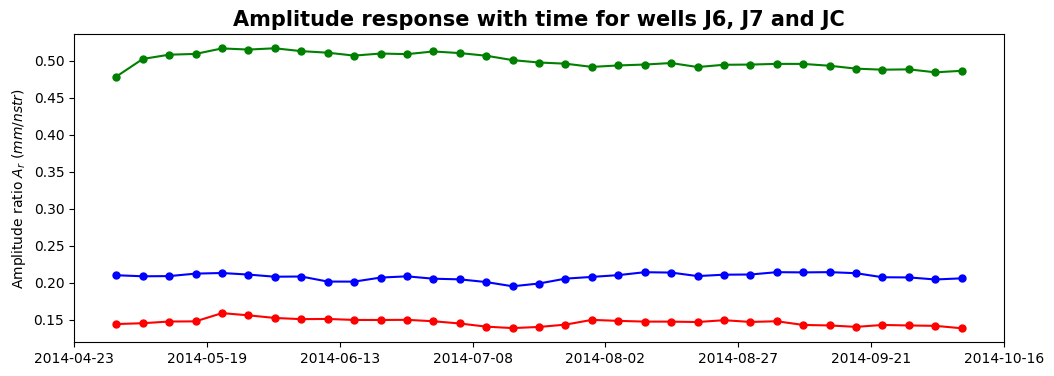

In [121]:
# J6_Ar=np.asarray(J6_gwamp)/ np.asarray(ET_amp)*1e9
# J7_Ar=np.asarray(J7_gwamp)/ np.asarray(ET_amp)*1e9
# JC_Ar=np.asarray(JC_gwamp)/ np.asarray(ET_amp)*1e9
fig=plt.figure(figsize=(12, 4))
ax=fig.add_subplot(111)
ax.set_title('Amplitude response with time for wells J6, J7 and JC',fontsize=15, fontweight='bold')
ax.plot(Date,J6_Ar*1e-6, 'b.-', ms=10,label='Well_J6 ')
ax.plot(Date,J7_Ar*1e-6, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,JC_Ar*1e-6, 'g.-', ms=10,label='Well_JC ')
ax.set_ylabel("Amplitude ratio $A_r$ ($mm/nstr$)",fontsize=10)
ax.xaxis.set_major_locator(ticker.LinearLocator(8))
# ax.axvline(x=Date[80],ls="--",c="#E3072A")
# #ax.axhline(y=1,ls="--",c="#E3072A")
# print(Date[80])
# ax.text(Date[80],0.25,' earthquake',  rotation=-90)
# ax.legend(prop=font1)

fig.savefig('del jump_A.svg',bbox_inches='tight')
fig.savefig('202303deljumpA.png',bbox_inches='tight')

In [122]:
VJ7_Ps = list(filter(lambda x: x > 0, J7_Ps))
HJ7_Ps = list(filter(lambda x: x < 0, J7_Ps))
VJ7_Ps=np.asarray(VJ7_Ps)
HJ7_Ps=np.asarray(HJ7_Ps)
HJ7_Ar=J7_Ar[0:len(HJ7_Ps)]
VJ7_Ar=J7_Ar[len(HJ7_Ps):]
VJ7_Ar=np.asarray(VJ7_Ar)
print((VJ7_Ar))
#print(VJ7_Ps)
#print(len(HJ7_Ps))
VJC_Ps = list(filter(lambda x: x > 0, JC_Ps))
HJC_Ps = list(filter(lambda x: x < 0, JC_Ps))
VJC_Ps=np.asarray(VJC_Ps)
HJC_Ps=np.asarray(HJC_Ps)
# negative_indices = [i for i, x in enumerate(JC_Ps) if x > 0]
# #print(negative_indices)
# VJC_Ps=JC_Ps[negative_indices[0]:negative_indices[len(negative_indices)-1]+1]
# VJC_Ar=JC_Ar[negative_indices[0]:negative_indices[len(negative_indices)-1]+1]
# #print(VJ7_Ps)
# HJC_Ps1=JC_Ps[0:negative_indices[0]]
# HJC_Ar1=JC_Ar[0:negative_indices[0]]
# HJC_Ps2=JC_Ps[negative_indices[len(negative_indices)-1]+1:]
# HJC_Ar2=JC_Ar[negative_indices[len(negative_indices)-1]+1:]
#print(VJC_Ps)

[143949.07814823 145070.12086924 147361.09656266 147576.22652798
 158705.5721156  155760.43611243 152189.44444016 150578.06253479
 150864.916441   149490.90870101 149448.875224   149655.50350135
 147749.9973024  144710.87981768 140443.16132081 138493.14611137
 140031.35263853 143167.46672406 149590.87794424 148247.30731161
 147271.23304399 147238.55724473 146684.84041252 149152.68482787
 146822.06684768 147727.51445208 142736.91292184 142052.10060414
 140135.81606116 142720.78664232 142046.35471037 141526.12128518
 138236.71659944]


In [123]:
freq = 1.932274

global Ker, Kei, power, sqrt
Ker = np.frompyfunc(mp.ker, 2, 1)
Kei = np.frompyfunc(mp.kei, 2, 1)
power = np.frompyfunc(mp.power, 2, 1)
sqrt = np.frompyfunc(mp.sqrt, 1, 1)
# the horizontal flow / negative phase model
def et_hflow(K, S_s, r_w=0.1, r_c=0.1, b=2, f=freq):
    global Ker, Kei, power, sqrt
    # create numpy function from mpmath
    # https://stackoverflow.com/questions/51971328/how-to-evaluate-a-numpy-array-inside-an-mpmath-fuction
    D_h = K / S_s
    omega = 2*np.pi*freq
    tmp = omega / D_h
    # prevent errors from negative square roots
    if (tmp >= 0):
        T = K*b
        sqrt_of_2 = sqrt(2)
        alpha_w = r_w * sqrt(tmp)
        ker_0_alpha_w = Ker(0, alpha_w)
        ker_1_alpha_w = Ker(1, alpha_w)
        kei_0_alpha_w = Kei(0, alpha_w)
        kei_1_alpha_w = Kei(1, alpha_w)
        denom = power(ker_1_alpha_w, 2) + power(kei_1_alpha_w, 2)
        Psi = - (ker_1_alpha_w - kei_1_alpha_w) / (sqrt_of_2 * alpha_w * denom)
        Phi = - (ker_1_alpha_w + kei_1_alpha_w) / (sqrt_of_2 * alpha_w * denom)
        E = np.float64(1 - (((omega*power(r_c, 2))/(2*T)) * (Psi*ker_0_alpha_w + Phi*kei_0_alpha_w)))
        F = np.float64((((omega*power(r_c,2))/(2*T)) * (Phi*ker_0_alpha_w - Psi*kei_0_alpha_w)))
        Ar = (E**2 + F**2)**(-0.5)
        dPhi = -np.arctan(F/E)
        return Ar, dPhi
    else:
        return np.Inf, np.Inf

def fit_amp_phase(props, amp, phase, r_c, r_w, scr_len, freq):
    #print(props)
    K, S_s = props
    Ar, dPhi = et_hflow(K, S_s, r_c, r_w, scr_len, freq)
    res_amp = amp*S_s - Ar
    res_phase = phase - dPhi
    error = np.asarray([res_amp,res_phase])
#    print(error)
    return error

In [124]:
from scipy.special import kv
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import loguniform

# Properties of the aquifer
freq = 1.932274 # Frequency in days
R_W = 0.127
R_C = 0.127
R = 0.2 # distance from the well m (only for drawdown computation)
B_AQ = 84 # Aquifer depth m
B_LE = 100 # Leaky layer depth m
SKEMPTON = 0.5 # Skempton's coefficient [-]
BULK = 20000000000.0 

def et_vflow(K_AQ, S_AQ, K_LE, R_C, R_W, B_AQ, B_LE, freq):
    omega = 2 * np.pi * freq
    betta = ((K_LE / (K_AQ * B_AQ * B_LE)) + ((1j * omega * S_AQ * B_AQ) / (K_AQ * B_AQ))) ** 0.5
    argument = (1j * omega * S_AQ * B_AQ) / (1j * omega * S_AQ * B_AQ + K_LE / B_LE)
    xi = 1 + ((1j * omega * R_W) / (2 * K_AQ * B_AQ * betta)) * (kv(0, betta * R_W) / kv(1, betta * R_W)) * (R_C / R_W)**2
    # water level
    h_w = argument / xi
    return np.abs(h_w), np.angle(h_w, deg=True)
#%%

def Vfit_amp_phase(vars):
    K_AQ, S_AQ, K_LE = vars
    Ar, dPhi = et_vflow(K_AQ, S_AQ, K_LE, R_C, R_W, B_AQ, B_LE, freq)
    res_amp = amp - Ar
    res_phase = phase - dPhi
    error = np.asarray([res_amp, res_phase])
    return error

In [125]:
from scipy.optimize import least_squares

r_c=0.127/2
r_w=0.127/2
scr_len=78
J6K_list = []
J6Ss_list = []
for b in range(len(J6_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = J6_Ar[b]
    phase = J6_Ps[b]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    J6K_list.append(K)
    Ss = fit.x[1]
    J6Ss_list.append(Ss)

In [126]:

HJ7K_list = []
HJ7Ss_list = []
for i in range(len(HJ7_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = HJ7_Ar[i]
    phase = HJ7_Ps[i]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    HJ7K_list.append(K)
    Ss = fit.x[1]
    HJ7Ss_list.append(Ss)

In [127]:
##Estimate the part of J7 phase greater than 0
VJ7K_list = []
VJ7Ss_list = []
for i in range(len(VJ7_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = VJ7_Ar[i]*1e-6
    phase = VJ7_Ps[i]
    # least squares fitting
    fit =  least_squares(Vfit_amp_phase, [1E-7*24*3600, 1E-5, 1E-11*24*3600], bounds=([1e-10*24*3600,1e-10, 1E-16*24*3600], [1e-2*24*3600,1e-3,1E-2*24*3600]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    VJ7K_list.append(K)
    Ss = fit.x[1]
    VJ7Ss_list.append(Ss)

In [128]:
J7K=(HJ7K_list)+(VJ7K_list)
J7S=(HJ7Ss_list)+(VJ7Ss_list)

In [129]:
from scipy.optimize import least_squares

r_c=0.127/2
r_w=0.127/2
scr_len=78
JCK_list = []
JCSs_list = []
for b in range(len(JC_Ps)):
    #print("-------------------------------------------------")
    #print('Joint inversion of K and Ss:')
    amp = JC_Ar[b]
    phase = JC_Ps[b]*np.pi/180
    # least squares fitting
    fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
    #print(fit)

    # change units to m and s
    K = fit.x[0]/24/3600
    JCK_list.append(K)
    Ss = fit.x[1]
    JCSs_list.append(Ss)

In [130]:
# JCK1_list = []
# JCSs1_list = []
# for i in range(len(HJC_Ps1)):
#     #print("-------------------------------------------------")
#     #print('Joint inversion of K and Ss:')
#     amp = HJC_Ar1[i]
#     phase = HJC_Ps1[i]*np.pi/180
#     # least squares fitting
#     fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
#     #print(fit)

#     # change units to m and s
#     K = fit.x[0]/24/3600
#     JCK1_list.append(K)
#     Ss = fit.x[1]
#     JCSs1_list.append(Ss)

In [131]:
# JCK2_list = []
# JCSs2_list = []
# for i in range(len(HJC_Ps2)):
#     #print("-------------------------------------------------")
#     #print('Joint inversion of K and Ss:')
#     amp = HJC_Ar2[i]
#     phase = HJC_Ps2[i]*np.pi/180
#     # least squares fitting
#     fit =  least_squares(fit_amp_phase, [1e-7*24*3600, 1e-7], args=(amp, phase, r_c, r_w, scr_len, freq), xtol=3e-16, ftol=3e-16, gtol=3e-16, method='lm')
#     #print(fit)

#     # change units to m and s
#     K = fit.x[0]/24/3600
#     JCK2_list.append(K)
#     Ss = fit.x[1]
#     JCSs2_list.append(Ss)

In [132]:
# ##Estimate the part of J7 phase greater than 0
# VJCK_list = []
# VJCSs_list = []
# for i in range(len(VJC_Ps)):
#     #print("-------------------------------------------------")
#     #print('Joint inversion of K and Ss:')
#     amp = VJC_Ar[i]*1e-6
#     phase = VJC_Ps[i]
#     # least squares fitting
#     fit =  least_squares(Vfit_amp_phase, [1E-7*24*3600, 1E-5, 1E-11*24*3600], bounds=([1e-10*24*3600,1e-10, 1E-16*24*3600], [1e-2*24*3600,1e-3,1E-2*24*3600]), xtol=3e-16, ftol=3e-16, gtol=3e-16)
#     #print(fit)

#     # change units to m and s
#     K = fit.x[0]/24/3600
#     VJCK_list.append(K)
#     Ss = fit.x[1]
#     VJCSs_list.append(Ss)

In [133]:
# JCK=JCK1_list+VJCK_list+JCK2_list
JCK=np.asarray(JCK_list)

In [134]:
J6K=np.asarray(J6K_list)
J7K=np.asarray(J7K)
JCK=np.asarray(JCK)
J6S=np.asarray(J6Ss_list)
J7S=np.asarray(J7S)
JCS=np.asarray(JCSs_list)

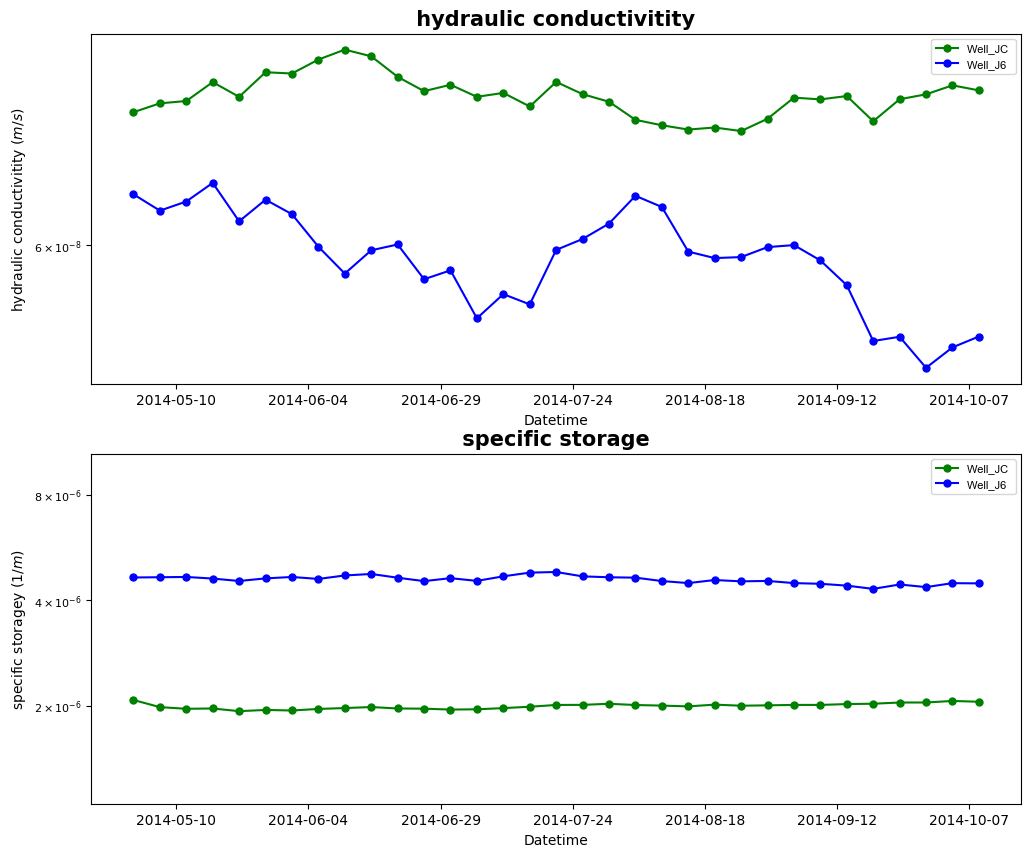

In [135]:
fig=plt.figure(figsize=(12, 10))
from matplotlib.ticker import MultipleLocator
ax=fig.add_subplot(211)
ax.set_title(' hydraulic conductivitity ',fontsize=15, fontweight='bold')
ax.plot(Date,JCK, 'g.-', ms=10,label='Well_JC ')
#ax.plot(Date,J7T, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,J6K, 'b.-', ms=10,label='Well_J6 ')



ax.set_ylabel("hydraulic conductivitity $(m/s)$",fontsize=10)
ax.set_xlabel("Datetime",fontsize=10)
#ax.set_ylim([1e-8, 1e-7])
ax.set_yscale("log")

ax.yaxis.set_major_locator(plt.LogLocator(base=2, numticks=6))
ax.yaxis.set_minor_locator(plt.LogLocator(base=2, numticks=3))

# 定义刻度格式化器，将刻度值格式化为以 $10^{k}$ 形式表示的字符串
class LogFormatterMathtext:
    def __call__(self, x, pos=None):
        if x == 0:
            return '0'
        else:
            exp = np.floor(np.log10(x))
            base = x / 10**exp
            if exp == 0:
                return '${:.0f}$'.format(x)
            else:
                return '${:.0f}\\times10^{{{:.0f}}}$'.format(base, exp)

# 设置 y 轴主刻度和子刻度的格式化器
ax.yaxis.set_major_formatter(LogFormatterMathtext())
ax.yaxis.set_minor_formatter(LogFormatterMathtext())

# 设置 y 轴标签的字体大小
ax.tick_params(axis='y', which='both', labelsize=8)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=25)) # 解决X轴密集问题
ax.legend(prop=font1)


#ax.axvline(x=Date[80],ls="--",c="#E3072A")

ax=fig.add_subplot(212)
ax.set_title(' specific storage ',fontsize=15, fontweight='bold')
ax.plot(Date,JCS, 'g.-', ms=10,label='Well_JC ')
#ax.plot(Date,J7T, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,J6S, 'b.-', ms=10,label='Well_J6 ')



ax.set_ylabel("specific storagey $(1/m)$",fontsize=10)
ax.set_xlabel("Datetime",fontsize=10)
ax.set_ylim([1e-6, 1e-5])
ax.set_yscale("log")

ax.yaxis.set_major_locator(plt.LogLocator(base=2, numticks=5))
ax.yaxis.set_minor_locator(plt.LogLocator(base=2, numticks=5))

# 定义刻度格式化器，将刻度值格式化为以 $10^{k}$ 形式表示的字符串
class LogFormatterMathtext:
    def __call__(self, x, pos=None):
        if x == 0:
            return '0'
        else:
            exp = np.floor(np.log10(x))
            base = x / 10**exp
            if exp == 0:
                return '${:.0f}$'.format(x)
            else:
                return '${:.0f}\\times10^{{{:.0f}}}$'.format(base, exp)

# 设置 y 轴主刻度和子刻度的格式化器
ax.yaxis.set_major_formatter(LogFormatterMathtext())
ax.yaxis.set_minor_formatter(LogFormatterMathtext())

# 设置 y 轴标签的字体大小
ax.tick_params(axis='y', which='both', labelsize=8)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=25)) # 解决X轴密集问题
ax.legend(prop=font1)


# ax.axvline(x=Date[80],ls="--",c="#E3072A")
# print(Date[80])
#ax.text(Date[80],2e-5,' earthquake',  rotation=-90)

fig.savefig('J6JC_K_Ss.svg',bbox_inches='tight')
fig.savefig('202303wellJ6JCKSs.png',bbox_inches='tight')

In [136]:
mu = 6.84*1e-4
rho =998.1
g = 9.81
perm=np.mean(JCK)*mu/rho/g
print(perm)

6.73989420154334e-15


In [137]:
import csv
with open('J_after K_Ss.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Date','J6K', 'J7K', 'JCK','J6Ss', 'J7Ss', 'JCSs'])
    for row in zip(Date,J6K, J7K, JCK,J6S, J7S, JCS):
        writer.writerow(row)

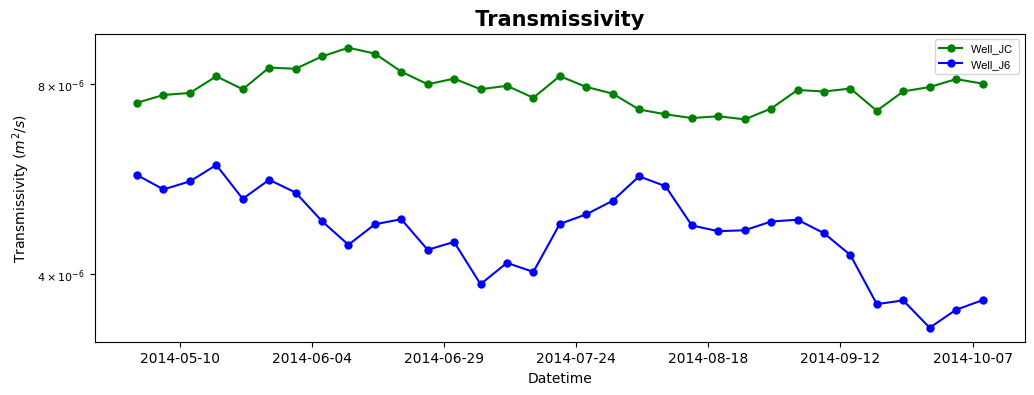

In [138]:
J6T=np.asarray(J6K_list)*78
J7T=np.asarray(J7K)*84
JCT=np.asarray(JCK)*78
fig=plt.figure(figsize=(12, 4))
from matplotlib.ticker import MultipleLocator
ax=fig.add_subplot(111)
ax.set_title(' Transmissivity ',fontsize=15, fontweight='bold')
ax.plot(Date,JCT, 'g.-', ms=10,label='Well_JC ')
#ax.plot(Date,J7T, 'r.-', ms=10,label='Well_J7 ')
ax.plot(Date,J6T, 'b.-', ms=10,label='Well_J6 ')



ax.set_ylabel("Transmissivity $(m^2/s)$",fontsize=10)
ax.set_xlabel("Datetime",fontsize=10)
#ax.set_ylim([1e-5, 1e-4])
ax.set_yscale("log")

ax.yaxis.set_major_locator(plt.LogLocator(base=2, numticks=6))
ax.yaxis.set_minor_locator(plt.LogLocator(base=2, numticks=3))

# 定义刻度格式化器，将刻度值格式化为以 $10^{k}$ 形式表示的字符串
class LogFormatterMathtext:
    def __call__(self, x, pos=None):
        if x == 0:
            return '0'
        else:
            exp = np.floor(np.log10(x))
            base = x / 10**exp
            if exp == 0:
                return '${:.0f}$'.format(x)
            else:
                return '${:.0f}\\times10^{{{:.0f}}}$'.format(base, exp)

# 设置 y 轴主刻度和子刻度的格式化器
ax.yaxis.set_major_formatter(LogFormatterMathtext())
ax.yaxis.set_minor_formatter(LogFormatterMathtext())

# 设置 y 轴标签的字体大小
ax.tick_params(axis='y', which='both', labelsize=8)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=25)) # 解决X轴密集问题
ax.legend(prop=font1)


# ax.axvline(x=Date[80],ls="--",c="#E3072A")
# print(Date[80])
#ax.text(Date[80],2e-5,' earthquake',  rotation=-90)

fig.savefig('J6JC_T.svg',bbox_inches='tight')
fig.savefig('202303wellJ6JCT.png',bbox_inches='tight')

In [139]:
with open('J_after Transmissivity.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Date','J6T', 'J7T', 'JCT'])
    for row in zip(Date,J6T, J7T, JCT):
        writer.writerow(row)

In [140]:
JCW=raw_data['JC [m]']
J7W=raw_data['J7 [m]']
J6W=raw_data['J6 [m]']

KeyError: 'JC [m]'

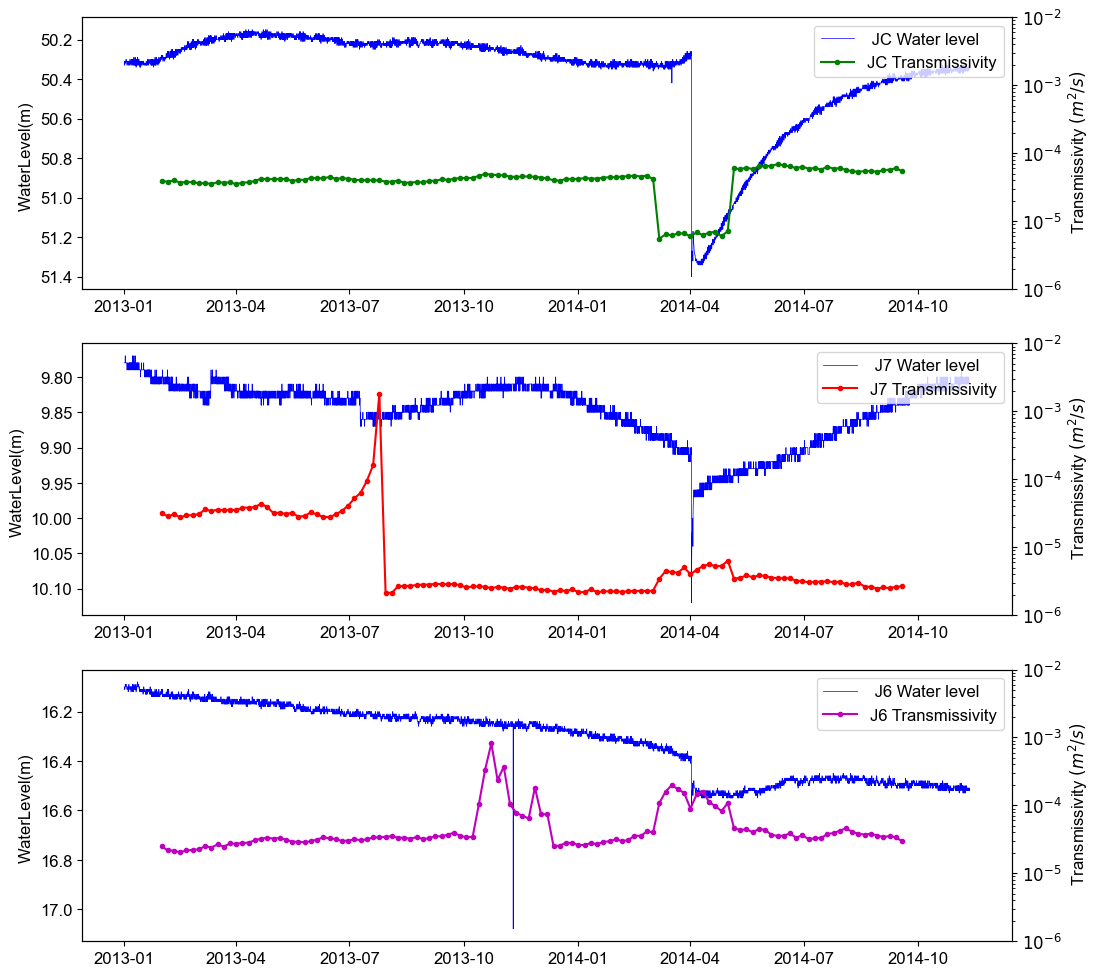

In [156]:
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 12,
}
fig1=plt.figure(figsize=(12,12))
ax1 = fig1.add_subplot(311)
lns1 = ax1.plot(raw_data[dt_col],JCW, c='b',lw=0.5,label=' JC Water level')
ax1.set_ylabel('WaterLevel(m) ',font1)
ax1.invert_yaxis()
ax1.legend(loc=2,prop=font1)
ax2=ax1.twinx()
lns2 = ax2.plot(Date,JCT,'g.-',label='JC Transmissivity')
ax2.set_ylabel(' Transmissivity $(m^2/s)$',font1)
ax2.set_ylim([1e-6, 1e-2])
ax2.set_yscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,prop=font1)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

ax1 = fig1.add_subplot(312)
lns1 = ax1.plot(raw_data[dt_col],J7W, c='b',lw=0.5,label=' J7 Water level')
ax1.set_ylabel('WaterLevel(m) ',font1)
ax1.invert_yaxis()
ax1.legend(loc=2,prop=font1)
ax2=ax1.twinx()
lns2 = ax2.plot(Date,J7T,'r.-',label='J7 Transmissivity')
ax2.set_ylabel(' Transmissivity $(m^2/s)$',font1)
ax2.set_ylim([1e-6, 1e-2])
ax2.set_yscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,prop=font1)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

ax1 = fig1.add_subplot(313)
lns1 = ax1.plot(raw_data[dt_col],J6W, c='b',lw=0.5,label=' J6 Water level')
ax1.set_ylabel('WaterLevel(m) ',font1)
ax1.invert_yaxis()
ax1.legend(loc=2,prop=font1)
ax2=ax1.twinx()
lns2 = ax2.plot(Date,J6T,'m.-',label='J6 Transmissivity')
ax2.set_ylabel(' Transmissivity $(m^2/s)$',font1)
ax2.set_ylim([1e-6, 1e-2])
ax2.set_yscale("log")
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,prop=font1)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

fig1.savefig('202303wellJCJ6JCC.svg',bbox_inches='tight')